In [1]:
import csv
import cv2
import numpy as np
from keras.layers import Input, Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.models import Sequential
images = []
labels = []
print('Libraries imported!')

Using TensorFlow backend.


Libraries imported!


In [2]:
import boto3

s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
s3_client.download_file('driving-data', 'driving_log.csv', 'data/driving_log.csv')


In [3]:
from PIL import Image
import io
# key = "IMG/center_2016_12_01_13_30_48_287.jpg"
# image_obj = s3.Object('driving-data', key)
# image = image_obj.get()['Body'].read()
# image = Image.open(io.BytesIO(image))
# image= np.asarray( image, dtype="int32" )

In [9]:
#reading images and steering angles
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


CENTER =0
LEFT= 1
RIGHT= 2
correction = 0.2

def load_data_from_s3(path):
    data =[]
    
    with open('{}/driving_log.csv'.format(path)) as csvfile:
        reader = csv.reader(csvfile)
        line_count = 0
        for line in reader:
            if line_count>0:
                steering_angle = float(line[3])
                center = [line[0], steering_angle]
                left= [line[1], steering_angle+correction]
                right= [line[2], steering_angle-correction]
                flip = [line[0], -1*steering_angle, 'flip']
                data.extend((center,left,right, flip))
            line_count+=1
    return data

def get_image(bucket,sample):
    try:
        image_name = sample[0].split('/')[-1]
        key= 'IMG/{}'.format(image_name)
        image_obj = s3.Object(bucket, key)
        image = io.BytesIO(image_obj.get()['Body'].read())
        image = Image.open(image)
        image= np.asarray( image, dtype="int32" )
        #correct_path = "{}/IMG/{}".format(path,image_name)
        #image = cv2.imread(correct_path)
        if sample[-1] == 'flip':
            image = np.fliplr(image)
        return image
    except Exception as err:
        print(err)


def generator(bucket,samples, batch_size = 32):
    while True:
        for offset in range(0,len(samples), batch_size):
            start = offset
            end = offset+batch_size
            batch_sample = samples[start:end]
            images=[]
            angles=[]
            for sample in batch_sample:
                #get images
                image = get_image(bucket,sample)
                
                images.append(image)
                #get steering angles
                steer = float(sample[1])
                angles.append(steer)
                
            x = np.array(images)
            y = np.array(angles)
            yield shuffle(x,y)

In [10]:
bucket = 'driving-data'
path = 'data'
data = load_data_from_s3(path)
train_data, validation_data = train_test_split(data, test_size=0.2)
print(len(data))
print(len(train_data))
print(len(validation_data))

train_generator = generator(bucket,train_data, batch_size = 32)
validation_generator = generator(bucket,validation_data, batch_size =32)


32144
25715
6429


In [6]:
import os
#model architecture
model = Sequential()
model.add(Lambda(lambda train_generator:(train_generator/250.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
# if os.path.isfile('model.h5'):
#     print('loading features')
#     model.load_weights('features.h5')
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator,samples_per_epoch=len(train_data),nb_epoch=5,nb_val_samples=len(validation_data), validation_data = validation_generator, verbose=1)
# model.save_weights('features.h5')
model.save('model.h5')

Epoch 1/5
25715/25715 [==============================] - 1280s - loss: 0.0173 - val_loss: 0.0161

dict_keys(['loss', 'val_loss'])


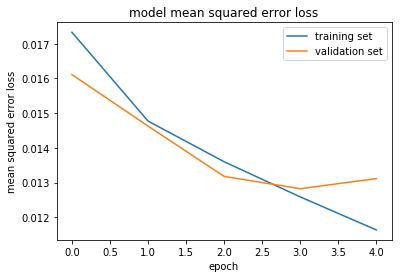

In [7]:
#plotting data_1
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [17]:
bucket2 = 'driving-data2'
path2 = 'data2'
s3_client.download_file('driving-data2', 'driving_log.csv', 'data2/driving_log.csv')

data2 = load_data_from_s3(path2)
train_data2, validation_data2 = train_test_split(data2, test_size=0.2)
print(len(data2))
print(len(train_data2))
print(len(validation_data2))

71744
57395
14349


In [21]:


train_generator2 = generator(bucket2,train_data2, batch_size = 32)
validation_generator2 = generator(bucket2,validation_data2, batch_size =32)

model2 = Sequential()
model2.add(Lambda(lambda train_generator2:(train_generator2/250.0)-0.5, input_shape=(160,320,3)))
model2.add(Cropping2D(cropping=((70,25),(0,0))))
model2.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model2.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model2.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model2.add(Convolution2D(64,3,3,activation='relu'))
model2.add(Convolution2D(64,3,3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(100))
model2.add(Dense(50))
model2.add(Dense(10))
model2.add(Dense(1))
# if os.path.isfile('model.h5'):
#     print('loading features')
#     model.load_weights('features.h5')
model2.compile(loss='mse', optimizer='adam')
history_object2 = model2.fit_generator(train_generator2,samples_per_epoch=len(train_data2),nb_epoch=5,nb_val_samples=len(validation_data2), validation_data = validation_generator2, verbose=1)


Epoch 1/5
57395/57395 [==============================] - 4285s - loss: 0.0653 - val_loss: 0.0538

In [ ]:
#plotting data_1
import matplotlib.pyplot as plt
print(history_object2.history.keys())
plt.plot(history_object2.history['loss'])
plt.plot(history_object2.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()